API key: 71F522PIQRFAFZZO

In [30]:
import os
import json
import requests

import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt


In [31]:
#! pip install bokeh

In [32]:
os.makedirs("data", exist_ok=True)
os.makedirs("visualisations", exist_ok=True)

intraday data

In [33]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=GME&outputsize=full&interval=60min&apikey=71F522PIQRFAFZZO'
r = requests.get(url)
gme_intraday_data = r.json()

with open("data/gme_intraday_data.json", "w") as f:
    json.dump(gme_intraday_data, f)

In [34]:
# First, the JSON data was read into a DataFrame
gme_df_uploaded = pd.read_json('data/gme_intraday_data.json')

# Extracting the time series data from the 'Time Series (60min)' column
time_series_data = gme_df_uploaded['Time Series (60min)'].dropna().to_dict()

# Creating a new DataFrame with the structured data
gme_transformed_df = pd.DataFrame.from_dict(time_series_data, orient='index')
gme_transformed_df.reset_index(inplace=True)
gme_transformed_df.rename(columns={'index': 'Date/Time'}, inplace=True)

# Displaying the first few rows of the transformed DataFrame
gme_transformed_df.head()


,Date/Time,1. open,2. high,3. low,4. close,5. volume
0,2023-12-06 19:00:00,14.8400,14.8400,13.8500,13.9600,290329
1,2023-12-06 18:00:00,14.3700,14.8400,14.3700,14.4200,179111
2,2023-12-06 17:00:00,14.3800,14.8400,14.3500,14.3700,222513
3,2023-12-06 16:00:00,14.8400,15.5600,14.0000,14.3980,1915840
4,2023-12-06 15:00:00,14.8700,14.9400,14.6400,14.8300,2175783


daily data

In [35]:
# File path for the JSON data
file_path = "data/gme_daily_data.json"

# Check if the file already exists
if not os.path.exists(file_path):
    # Fetch the data only if the file does not exist
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=GME&outputsize=full&apikey=71F522PIQRFAFZZO'
    response = requests.get(url)
    gme_daily_data = response.json()

    # Save the data to a JSON file
    with open(file_path, "w") as file:
        json.dump(gme_daily_data, file)

In [36]:
# Reading the JSON file
gme_daily_data_df = pd.read_json('data/gme_daily_data.json')

# Extracting the relevant time series data
time_series_daily_data = gme_daily_data_df['Time Series (Daily)'].dropna().to_dict()

# Creating a new DataFrame with the structured data
gme_daily_transformed_df = pd.DataFrame.from_dict(time_series_daily_data, orient='index')
gme_daily_transformed_df.reset_index(inplace=True)
gme_daily_transformed_df.rename(columns={'index': 'Date', '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'}, inplace=True)
gme_daily_transformed_df_sorted = gme_daily_transformed_df.sort_index()

# Displaying the first few rows of the transformed DataFrame
gme_daily_transformed_df_sorted.head()




,Date,Open,High,Low,Close,Volume
0,2023-11-24,12.2200,12.4100,12.1750,12.2000,1232474
1,2023-11-22,12.5600,12.7100,12.1901,12.2900,2362461
2,2023-11-21,12.6500,12.7200,12.2550,12.5500,3710097
3,2023-11-20,13.0000,13.2000,12.8000,12.8000,2301584
4,2023-11-17,12.5200,13.0550,12.5200,13.0300,3422596


Changing datatypes

In [37]:
gme_daily_transformed_df = gme_daily_transformed_df.astype({
    'Date': 'datetime64[ns]',
    'Open': 'float',
    'High': 'float',
    'Low': 'float',
    'Close': 'float',
    'Volume': 'float'
})

print(gme_daily_transformed_df.head())

        Date   Open    High      Low  Close     Volume
0 2023-11-24  12.22  12.410  12.1750  12.20  1232474.0
1 2023-11-22  12.56  12.710  12.1901  12.29  2362461.0
2 2023-11-21  12.65  12.720  12.2550  12.55  3710097.0
3 2023-11-20  13.00  13.200  12.8000  12.80  2301584.0
4 2023-11-17  12.52  13.055  12.5200  13.03  3422596.0


Filtering dataframe to only include dates in the relevant period

In [38]:
# Filtering the DataFrame to include only data from December 2020 to April 2021 and creating a copy
gme_jan_apr2021_df = gme_daily_transformed_df[(gme_daily_transformed_df['Date'] >= '2021-01-01') & (gme_daily_transformed_df['Date'] <= '2021-04-01')].copy()

Plotting Close price against Date - PRACTICE

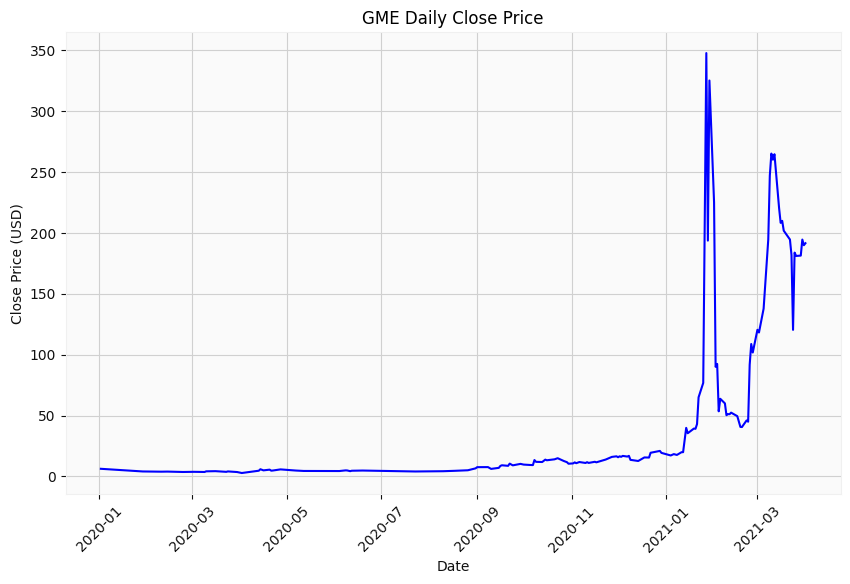

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(gme_jan_apr2021_df['Date'], gme_jan_apr2021_df['Close'], color='blue')
plt.title('GME Daily Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Plotting a Candlestick Chart of GME Stock Price during the Gamestop short squeeze

In [40]:
# Ensure 'Date' is the index
gme_jan_apr2021_df.set_index('Date', inplace=True)

# Sorting the DataFrame by 'Date' in ascending order
gme_jan_apr2021_df.sort_index(inplace=True)

# Plotting the OHLC candlestick chart
mpf.plot(gme_jan_apr2021_df, 
         type='candle', 
         style='yahoo', 
         volume=True, 
         #tight_layout=True,
         datetime_format='%b %d, %Y',
         xrotation=45,
         title='GME Stock Price (Dec 2020-Apr 2021)',
         savefig='visualisations/gme_stock_price_candlestick_chart.png')


In [41]:
df_data1 = pd.read_csv('./data/reddit_data/Submissions_2021-01_FilteredBySubreddit_GME.csv')
df_data2 = pd.read_csv('./data/reddit_data/Submissions_2021-02_FilteredBySubreddit_GME.csv')
df_data3 = pd.read_csv('./data/reddit_data/Submissions_2021-03_FilteredBySubreddit_GME.csv')

df_all_data = pd.concat([df_data1, df_data2, df_data3], axis = 0,
                        ignore_index=True)

In [42]:
df_all_data.tail()

,submission_id,redditor_name,created_at,title,text,subreddit,permalink,attachment,flair,score,num_comments,edited
1059845,mhj0xa,MoRaLoSeVisH_13,2021-04-01T00:57:18,"Soon , fellow 🦍🦍🦍",NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/m8to12bkcgq61.jpg'},"{'link': 'Loss', 'author': None}",{'2021-06-11T22:41:01': 1},{'2021-06-11T22:41:01': 1},False
1059846,mhj0yj,[deleted],2021-04-01T00:57:22,Miley Cryus giving away $50 of free stock via ...,[removed],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'Discussion', 'author': None}",{'2021-06-11T22:41:01': 1},{'2021-06-11T22:41:01': 0},False
1059847,mhj103,lexmark0331,2021-04-01T00:57:26,HOFV Mega squeeze Opportunity,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/vca4pnalcgq61.jpg'},"{'link': 'DD', 'author': None}",{'2021-06-11T22:41:01': 1},{'2021-06-11T22:41:01': 1},False
1059848,mhj272,chefthmst1983,2021-04-01T00:59:33,So what happened end of day on the DOW...hell ...,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/n3oh1tvycgq61.jpg'},"{'link': 'Discussion', 'author': None}",{'2021-06-11T22:41:03': 1},{'2021-06-11T22:41:03': 0},False
1059849,mhj29n,KingMacias1,2021-04-01T00:59:41,We made it to Vice News you dirty apes 🦍,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/wygxtrdzcgq61.jpg'},"{'link': 'News', 'author': None}",{'2021-06-11T22:41:03': 1},{'2021-06-11T22:41:03': 1},False


In [43]:
# Remove curly brackets from num_comments and score columns
df_all_data['num_comments'] = df_all_data['num_comments'].str.replace('[{}]'.format(''.join(['{}'])), '', regex=True)
df_all_data['score'] = df_all_data['score'].str.replace('[{}]'.format(''.join(['{}'])), '', regex=True)


# Remove date and time from num_comments and score columns
df_all_data['num_comments'] = df_all_data['num_comments'].str.split(':').str[-1].str.strip()
df_all_data['score'] = df_all_data['score'].str.split(':').str[-1].str.strip()


# Convert num_comments and score columns to integers
df_all_data['num_comments'] = df_all_data['num_comments'].astype(int)
df_all_data['score'] = df_all_data['score'].astype(int)


df_all_data['created_at'] = pd.to_datetime(df_all_data['created_at'])
df_all_data['created_at'] = df_all_data['created_at'].dt.strftime('%Y-%m-%d')

KeyboardInterrupt: 

In [ ]:
df_all_data.tail()

,submission_id,redditor_name,created_at,title,text,subreddit,permalink,attachment,flair,score,num_comments,edited
1059845,mhj0xa,MoRaLoSeVisH_13,2021-04-01,"Soon , fellow 🦍🦍🦍",NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/m8to12bkcgq61.jpg'},"{'link': 'Loss', 'author': None}",1,1,False
1059846,mhj0yj,[deleted],2021-04-01,Miley Cryus giving away $50 of free stock via ...,[removed],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'Discussion', 'author': None}",1,0,False
1059847,mhj103,lexmark0331,2021-04-01,HOFV Mega squeeze Opportunity,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/vca4pnalcgq61.jpg'},"{'link': 'DD', 'author': None}",1,1,False
1059848,mhj272,chefthmst1983,2021-04-01,So what happened end of day on the DOW...hell ...,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/n3oh1tvycgq61.jpg'},"{'link': 'Discussion', 'author': None}",1,0,False
1059849,mhj29n,KingMacias1,2021-04-01,We made it to Vice News you dirty apes 🦍,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/wygxtrdzcgq61.jpg'},"{'link': 'News', 'author': None}",1,1,False


Groupby - keep looking into

In [ ]:
df_all_data.rename(columns={'created_at': 'Date'}, inplace=True)
df_grouped = df_all_data.groupby('Date')

df_grouped = df_all_data.groupby('Date').size().reset_index(name='Post_Count')

df_grouped


# Now, you can perform operations on each group
# For example, you can calculate the sum of 'score' and 'num_comments' for each date
#result = df_grouped[['score', 'num_comments']].sum()

# The result DataFrame will have 'created_at' date as the index and sum of 'score' and 'num_comments' for each date
#print(result)

,Date,Post_Count
0,2021-01-01,589
1,2021-01-02,625
2,2021-01-03,613
3,2021-01-04,1029
4,2021-01-05,965
...,...,...
86,2021-03-28,1178
87,2021-03-29,2065
88,2021-03-30,2105
89,2021-03-31,2147


In [ ]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, HoverTool
from bokeh.io import curdoc
import datetime

In [ ]:
# Set 'Date' as the DataFrame index
#gme_jan_apr2021_df.set_index('Date', inplace=True)

# Create a ColumnDataSource for Bokeh plotting
source = ColumnDataSource(data=gme_jan_apr2021_df)

# Create the figure
p = figure(title="GME Daily Closing Prices (Dec 2020 - Apr 2021)", 
           x_axis_label='Date', y_axis_label='Close Price ($)', 
           x_axis_type='datetime', width=800, height=400)

# Add a line renderer with legend and line thickness
p.line(x='Date', y='Close', source=source, legend_label="Close Price", line_width=2)

# Updated format for the datetime axis
p.xaxis.formatter = DatetimeTickFormatter(
    days="%d %b %Y",
    months="%b %Y",
    years="%Y"
)

# Add a hover tool to the plot
hover = HoverTool(
    tooltips=[
        ('Date', '@Date{%F}'),  # Use the { } to format the date
        ('Close', '$@Close{0,0.00}')  # Use { } to format the close price
    ],
    formatters={
        '@Date': 'datetime',  # Use 'datetime' formatter for '@Date' field
    },
    mode='vline'  # Display a tooltip whenever the cursor is vertically in line with a glyph
)

p.add_tools(hover)

# Updated format for the datetime axis
p.xaxis.formatter = DatetimeTickFormatter(
    days="%d %b %Y",
    months="%b %Y",
    years="%Y"
)

output_notebook()
show(p)

Loading BokehJS ...

In [ ]:
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [4, 5, 5, 7, 2, 6, 4, 9, 1, 3]

# create plot with circle glyphs
p = figure(x_range=(1, 9), width=500, height=250)
points = p.circle(x=x, y=y, size=30, fill_color="#21a7df")

# set up textarea (div)
div = Div(
    text="""
          <p>Select the circle's size using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up spinner
spinner = Spinner(
    title="Circle size",
    low=0,
    high=60,
    step=5,
    value=points.glyph.size,
    width=200,
)
spinner.js_link("value", points.glyph, "size")

# set up RangeSlider
range_slider = RangeSlider(
    title="Adjust x-axis range",
    start=0,
    end=10,
    step=1,
    value=(p.x_range.start, p.x_range.end),
)
range_slider.js_link("value", p.x_range, "start", attr_selector=0)
range_slider.js_link("value", p.x_range, "end", attr_selector=1)

# create layout
layout = layout(
    [
        [div, spinner],
        [range_slider],
        [p],
    ],
)

# show result
show(layout)